In [1]:
#####Nested Directed Graph Embedding model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id
    if pattern==1:
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z

In [3]:
####データの生成####
##データの設定
k11 = 7
k21 = 8
k12 = 9
k22 = 9
item = 3000
event = 2500
Lambda = np.random.gamma(30.0, 1/0.2, item)
pt = np.random.poisson(Lambda, item)
N = np.sum(pt)
k_vec1 = np.repeat(1.0, k12)
k_vec2 = np.repeat(1.0, k22)

In [4]:
##IDとインデックスの作成
#IDの作成
item_id = np.repeat(np.arange(item), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(item)])))

#インデックスの作成
item_list = [i for i in range(item)]
for i in range(item):
    item_list[i] = np.array(np.where(item_id==i)[0], dtype="int")
    
#全結合変数の割当インデックス
allocation1 = np.repeat(np.arange(k11), k21)
allocation2 = np.tile(np.arange(k21), k11)

In [5]:
##eventの割当を生成
#トピック割当を生成
topic = 25
phi = np.random.dirichlet(np.repeat(0.5, event), topic)
theta = np.random.dirichlet(np.repeat(0.5, topic), item)
z = np.dot(np.array([np.random.multinomial(1, theta[i, :], 1) for i in range(item)]).reshape(item, topic), range(topic))

#多項分布からアイテムを生成
event_id = np.zeros(N, dtype='int')
for i in range(item):
    if i%1000==0:
        print(i)
    event_id[item_list[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt[i]), range(event))
    
#インデックスの作成
event_list = [i for i in range(event)]
event_n = np.repeat(0, event)
for i in range(event):
    event_list[i] = np.array(np.where(event_id==i)[0], dtype="int")
    event_n[i] = event_list[i].shape[0]

0
1000
2000


In [6]:
####応答変数の生成####
per_min = 100; per_max = 100
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    ##パラメータの生成
    #階層モデルの事前分布のパラメータ
    alpha11 = np.repeat(0.0, k11)
    alpha21 = np.repeat(1.0, k21)
    alpha12 = np.repeat(0.0, k12)
    alpha22 = np.repeat(0.0, k22)
    Cov_v11 = np.diag(np.repeat(0.4, k11))
    Cov_v21 = np.diag(np.repeat(0.4, k21))
    Cov_v12 = np.diag(np.repeat(0.4, k12))
    Cov_v22 = np.diag(np.repeat(0.4, k22))
    tau1 = np.array([0.5])
    tau2 = np.array([0.5])
    Covt_v11 = Cov_v11.copy(); Covt_v21 = Cov_v21.copy()
    Covt_v12 = Cov_v12.copy(); Covt_v22 = Cov_v22.copy()
    taut1 = tau1.copy(); taut2 = tau2.copy()

    #モデルパラメータを生成
    beta = np.array([-1.0])
    theta_v11 = np.random.multivariate_normal(alpha11, Cov_v11, item)
    theta_v12 = np.random.multivariate_normal(alpha12, Cov_v12, item)
    theta_v21 = np.random.multivariate_normal(alpha21, Cov_v21, event)
    theta_v22 = np.random.multivariate_normal(alpha22, Cov_v22, event)
    omega1 = np.random.normal(0, tau1, k11*k21).reshape(k11, k21)
    omega21 = np.random.normal(0, tau2, k11*k21*k12).reshape(k11*k21, k12)
    omega22 = np.random.normal(0, tau2, k11*k21*k22).reshape(k11*k21, k22)
    Sigma = np.array([1.0])
    betat = beta.copy()
    thetat_v11 = theta_v11.copy(); thetat_v12 = theta_v12.copy()
    thetat_v21 = theta_v21.copy(); thetat_v22 = theta_v22.copy()
    omegat1 = omega1.copy(); omegat21 = omega21.copy(); omegat22 = omega22.copy()

    ##正規分布から潜在変数を生成
    #モデルの期待値
    nested_uv = theta_v11[:, allocation1][item_id, ] * theta_v21[:, allocation2][event_id, ] * omega1.reshape(-1)
    uv1 = np.dot(np.dot(nested_uv, omega21) * theta_v12[item_id, ], k_vec1)
    uv2 = np.dot(np.dot(nested_uv, omega22) * theta_v22[event_id, ], k_vec2)
    mu1 = beta + uv1; mu2 = beta + uv2

    #潜在変数の生成と二値変数への変換
    U1 = np.random.normal(mu1, Sigma, N)
    U2 = np.random.normal(mu2, Sigma, N)
    y1 = (U1 >= 0)*1 + (U1 < 0)*0; y2 = (U2 >= 0)*1 + (U2 < 0)*0
    Prob1 = norm.cdf(mu1, 0, Sigma); Prob2 = norm.cdf(mu2, 0, Sigma)

    #break条件
    if ((np.mean(y1) > 0.2) & (np.mean(y1) < 0.4) & (np.mean(y2) > 0.2) & (np.mean(y2) < 0.4) &
        (np.sum(U1 <= -7.5) < N/per_min) & (np.sum(U1 > 7.5) < N/per_max) & 
        (np.sum(U2 <= -7.5) < N/per_min) & (np.sum(U2 > 7.5) < N/per_max)):
            break

1
2
3
4
5
6
7
8
9


In [8]:
nested_uv.shape

(450574, 56)

In [7]:
#### 応答変数をリストに格納
mu = [mu1, mu2]
U = [U1, U2]
y = [y1, y2]
Prob = [Prob1, Prob2]

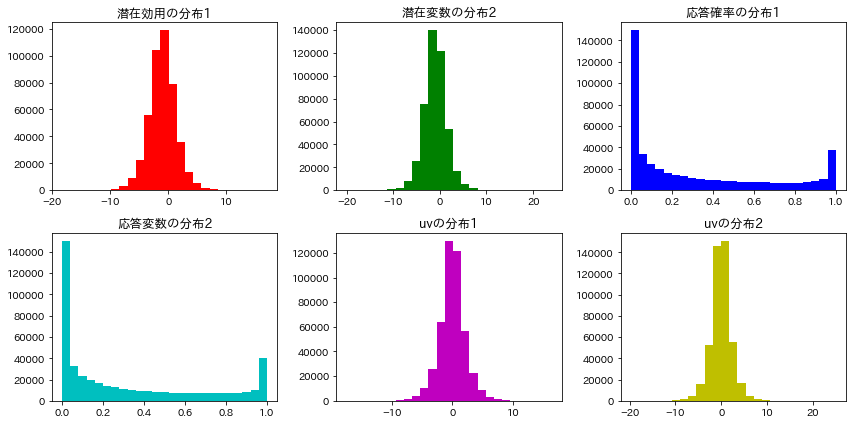

In [8]:
#潜在変数ごとのヒストグラム
dt = [U1, U2, Prob1, Prob2, uv1, uv2]
fig_range = np.append(np.array([np.min(U1), np.min(U2), 0, 0, np.min(uv1), np.min(uv2)]), 
                      np.array([np.max(U1), np.max(U2), 1.0, 1.0, np.max(uv1), np.max(uv2)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["潜在効用の分布1", "潜在変数の分布2", "応答確率の分布1", "応答変数の分布2", "uvの分布1", "uvの分布2"]
fig = plt.figure(figsize=(12.0, 6.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [9]:
####Nested Directed Graph Embedding modelを推定####
##切断正規分布の乱数を発生させる関数
def rtnorm(mu, sigma, a, b, n):
    FA = norm.cdf(a, mu, sigma)
    FB = norm.cdf(b, mu, sigma)
    return norm.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu, sigma)

In [10]:
##アルゴリズムの設定
R = 2000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10
target_iter = 50

In [11]:
##データの設定
#切断領域を定義
type_n = 2
rho = 100.0
y = np.append(y1, y2)
a1 = np.array((1-y1)*(-rho) + y1*0)
b1 = np.array(y1*rho + (1-y1)*0)
a2 = np.array((1-y2)*(-rho) + y2*0)
b2 = np.array(y2*rho + (1-y2)*0)

#特徴行列の割当インデックス
allocation1 = np.repeat(np.arange(k11), k21)
allocation2 = np.tile(np.arange(k21), k11)
allocation_box1 = np.arange(k11*k21*k12).reshape(k11*k21, k12)
allocation_box2 = np.arange(k11*k21*k22).reshape(k11*k21, k22)
Z1 = np.full((k11*k21, k11), 0); Z2 = np.full((k11*k21, k21), 0)
for j in range(k11):
    Z1[allocation1==j, j] = 1
for j in range(k21):
    Z2[allocation2==j, j] = 1

In [12]:
##事前分布の設定
#階層モデルの事前分布
alpha11 = np.repeat(0.0, k11)
alpha21 = np.repeat(1.0, k21)
alpha12 = np.repeat(0.0, k12)
alpha22 = np.repeat(0.0, k22)
V11 = 0.1 * np.diag(np.ones(k11))
V21 = 0.1 * np.diag(np.ones(k21))
V12 = 0.1 * np.diag(np.ones(k12))
V22 = 0.1 * np.diag(np.ones(k22))
nu = 1.0

#モデルパラメータの事前分布
tau1 = np.diag(np.repeat(0.25, k11*k21*k12))
tau2 = np.diag(np.repeat(0.25, k11*k21*k22))
inv_tau1 = np.linalg.inv(tau1)
inv_tau2 = np.linalg.inv(tau2)
tau = 100 
s02 = 1.0
v02 = 1.0

In [13]:
##パラメータの真値
#階層モデルのパラメータの真値
Cov_v11 = Covt_v11.copy(); inv_Cov_v11 = np.linalg.inv(Cov_v11)
Cov_v12 = Covt_v12.copy(); inv_Cov_v12 = np.linalg.inv(Cov_v12)
Cov_v21 = Covt_v21.copy(); inv_Cov_v21 = np.linalg.inv(Cov_v21)
Cov_v22 = Covt_v22.copy(); inv_Cov_v22 = np.linalg.inv(Cov_v22)

#モデルパラメータの真値
Sigma = np.array([1.0])
beta = betat.copy()
theta_v11 = thetat_v11.copy()
theta_v12 = thetat_v12.copy()
theta_v21 = thetat_v21.copy()
theta_v22 = thetat_v22.copy()
omega1 = omegat1.copy()
omega21 = omegat21.copy()
omega22 = omegat22.copy()

#モデルの期待値
nested_uv = theta_v11[:, allocation1][item_id, ] * theta_v21[:, allocation2][event_id, ] * omega1.reshape(-1)
uv1 = np.dot(np.dot(nested_uv, omega21) * theta_v12[item_id, ], k_vec1)
uv2 = np.dot(np.dot(nested_uv, omega22) * theta_v22[event_id, ], k_vec2)
mu1 = beta + uv1; mu2 = beta + uv2

In [14]:
##パラメータの初期値
#階層モデルのパラメータの初期値
Cov_v11 = np.diag(np.repeat(0.25, k11)); inv_Cov_v11 = np.linalg.inv(Cov_v11)
Cov_v12 = np.diag(np.repeat(0.25, k12)); inv_Cov_v12 = np.linalg.inv(Cov_v12)
Cov_v21 = np.diag(np.repeat(0.25, k21)); inv_Cov_v21 = np.linalg.inv(Cov_v21)
Cov_v22 = np.diag(np.repeat(0.25, k22)); inv_Cov_v22 = np.linalg.inv(Cov_v22)

#モデルパラメータの初期値
Sigma = np.array([1.0])
beta = np.array([-1.0])
theta_v11 = np.random.multivariate_normal(alpha11, Cov_v11, item)
theta_v12 = np.random.multivariate_normal(alpha12, Cov_v12, item)
theta_v21 = np.random.multivariate_normal(alpha21, Cov_v21, event)
theta_v22 = np.random.multivariate_normal(alpha22, Cov_v22, event)
omega1 = np.random.normal(0, 0.25, k11*k21).reshape(k11, k21)
omega21 = np.random.normal(0, 0.25, k11*k21*k12).reshape(k11*k21, k12)
omega22 = np.random.normal(0, 0.25, k11*k21*k22).reshape(k11*k21, k22)

#モデルの期待値
nested_uv = theta_v11[:, allocation1][item_id, ] * theta_v21[:, allocation2][event_id, ] * omega1.reshape(-1)
uv1 = np.dot(np.dot(nested_uv, omega21) * theta_v12[item_id, ], k_vec1)
uv2 = np.dot(np.dot(nested_uv, omega22) * theta_v22[event_id, ], k_vec2)
mu1 = beta + uv1; mu2 = beta + uv2

In [15]:
##パラメータの格納用配列
#階層モデルの格納用配列
COV_V11 = np.zeros((k11, k11, int(R/keep)))
COV_V12 = np.zeros((k12, k12, int(R/keep)))
COV_V21 = np.zeros((k21, k21, int(R/keep)))
COV_V22 = np.zeros((k22, k22, int(R/keep)))

#モデルパラメータの格納用配列
BETA = np.repeat(0.0, int(R/keep))
THETA_V11 = np.zeros((item, k11, int(R/keep)))
THETA_V12 = np.zeros((item, k12, int(R/keep)))
THETA_V21 = np.zeros((event, k21, int(R/keep)))
THETA_V22 = np.zeros((event, k22, int(R/keep)))
OMEGA1 = np.zeros((k11, k21, int(R/keep)))
OMEGA21 = np.zeros((k11*k21, k12, int(R/keep)))
OMEGA22 = np.zeros((k11*k21, k22, int(R/keep)))

In [16]:
##対数尤度の基準値
#1パラメータのモデルの対数尤度
Prob1 = np.mean(y1); Prob2 = np.mean(y2)
LLst1 = np.sum(y1*np.log(Prob1) + (1-y1)*np.log(1-Prob1))
LLst2 = np.sum(y2*np.log(Prob2) + (1-y2)*np.log(1-Prob2))
LLst = LLst1 + LLst2
print(np.round([LLst1, LLst2, LLst], 1))

#真値での対数尤度
nested_uv = thetat_v11[:, allocation1][item_id, ] * thetat_v21[:, allocation2][event_id, ] * omegat1.reshape(-1)
uv1 = np.dot(np.dot(nested_uv, omegat21) * thetat_v12[item_id, ], k_vec1)
uv2 = np.dot(np.dot(nested_uv, omegat22) * thetat_v22[event_id, ], k_vec2)
mu1 = betat + uv1; mu2 = betat + uv2
Prob1 = norm.cdf(mu1, 0, Sigma); Prob2 = norm.cdf(mu2, 0, Sigma)
Prob1[Prob1==1.0] = 0.9999999999; Prob1[Prob1==0] = np.power(10.0, -100)
Prob2[Prob2==1.0] = 0.9999999999; Prob2[Prob2==0] = np.power(10.0, -100)
LLbest1 = np.sum(y1*np.log(Prob1) + (1-y1)*np.log(1-Prob1))
LLbest2 = np.sum(y2*np.log(Prob2) + (1-y2)*np.log(1-Prob2))
LLbest = LLbest1 + LLbest2
print(np.round([LLbest1, LLbest2, LLbest], 1))

[-279556.3 -281592.5 -561148.8]
[-135428.6 -133723.7 -269152.3]


In [ ]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##切断正規分布から潜在効用を生成
    #モデルの期待値
    nested_uv = theta_v11[:, allocation1][item_id, ] * theta_v21[:, allocation2][event_id, ] * omega1.reshape(-1)
    uv1 = np.dot(np.dot(nested_uv, omega21) * theta_v12[item_id, ], k_vec1)
    uv2 = np.dot(np.dot(nested_uv, omega22) * theta_v22[event_id, ], k_vec2)
    mu1 = beta + uv1; mu2 = beta + uv2
    uv = np.append(uv1, uv2); mu = np.append(mu1, mu2)

    #潜在変数を生成
    U1 = np.array(rtnorm(mu1, Sigma, a1, b1, N))
    U2 = np.array(rtnorm(mu2, Sigma, a2, b2, N))
    U = np.append(U1, U2)


    ##モデルパラメータのサンプリング
    #モデル誤差を定義
    er_y = U - uv

    #正規分布から事後分布をサンプリング
    weights = tau / (Sigma/(2*N) + tau)
    mu_par = weights * np.mean(er_y)
    beta = np.random.normal(mu_par, weights*Sigma/(2*N), 1)


    ##ネストしたitemの特徴ベクトルをサンプリング
    #モデル誤差を定義
    er_y1 = U1 - beta
    er_y2 = U2 - beta

    #推定対象のパラメータを除去
    uv_directed1 = np.dot(theta_v12, omega21.T)[item_id, ]
    uv_directed2 = np.dot(theta_v22, omega22.T)[event_id, ]
    uv_deploy = theta_v21[:, allocation2][event_id, ] * omega1.reshape(-1)
    X1 = np.dot(uv_directed1 * uv_deploy, Z1)
    X2 = np.dot(uv_directed2 * uv_deploy, Z1)

    #多変量正規分布から事後分布をサンプリング
    for i in range(item):
        index = item_list[i] 
        x = np.vstack((X1[index, ], X2[index, ]))
        u = np.append(er_y1[index], er_y2[index])
        xy = np.dot(x.T, u)
        xxv = np.dot(x.T, x) + inv_Cov_v11
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(alpha11, inv_Cov_v11))
        theta_v11[i, ] = np.random.multivariate_normal(theta_par, Sigma*inv_xxv, 1)


    ##ネストしたeventの特徴ベクトルをサンプリング
    #推定対象のパラメータを除去
    uv_deploy = theta_v11[:, allocation1][item_id, ] * omega1.reshape(-1)
    X1 = np.dot(uv_directed1 * uv_deploy, Z2)
    X2 = np.dot(uv_directed2 * uv_deploy, Z2)

    #多変量正規分布から事後分布をサンプリング
    for i in range(event):
        index = event_list[i]
        x = np.vstack((X1[index, ], X2[index, ]))
        u = np.append(er_y1[index], er_y2[index])
        xy = np.dot(x.T, u)
        xxv = np.dot(x.T, x) + inv_Cov_v21
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(alpha21, inv_Cov_v21))
        theta_v21[i, ] = np.random.multivariate_normal(theta_par, Sigma*inv_xxv, 1)


    ##有向性のあるノードの特徴ベクトルをサンプリング
    #推定対象のパラメータを除去
    nested_uv = theta_v11[:, allocation1][item_id, ] * theta_v21[:, allocation2][event_id, ] * omega1.reshape(-1)
    X1 = np.dot(nested_uv, omega21)
    X2 = np.dot(nested_uv, omega22)

    #itemの事後分布をサンプリング
    for i in range(item):
        index = item_list[i]
        x1 = X1[index, ]; u1 = er_y1[index]
        xy1 = np.dot(x1.T, u1)
        xxv1 = np.dot(x1.T, x1) + inv_Cov_v12
        inv_xxv1 = np.linalg.inv(xxv1)
        theta_par1 = np.dot(inv_xxv1, xy1 + np.dot(alpha12, inv_Cov_v12))
        theta_v12[i, ] = np.random.multivariate_normal(theta_par1, Sigma*inv_xxv1, 1)

    #eventの事後分布をサンプリング
    for i in range(event):
        index = event_list[i]
        x2 = X2[index, ]; u2 = er_y2[index]
        xy2 = np.dot(x2.T, u2)
        xxv2 = np.dot(x2.T, x2) + inv_Cov_v22
        inv_xxv2 = np.linalg.inv(xxv2)
        theta_par2 = np.dot(inv_xxv2, xy2 + np.dot(alpha22, inv_Cov_v22))
        theta_v22[i, ] = np.random.multivariate_normal(theta_par2, Sigma*inv_xxv2, 1)


    ##双線形回帰行列をサンプリング
    #パラメータ推定のためのデータの定義
    theta_factor12 = theta_v12[item_id, ]
    theta_factor22 = theta_v22[event_id, ]

    #itemノードの事後分布のパラメータをサンプリング
    X = np.zeros((N, k11*k21*k12))
    for j in range(k12):
        X[:, allocation_box1[:, j]] = nested_uv * theta_factor12[:, np.array([j])]
    xy = np.dot(X.T, er_y1)
    xxv = np.dot(X.T, X) + inv_tau1
    inv_xxv = np.linalg.inv(xxv)
    omega_par = np.dot(inv_xxv, xy)
    omega21 = np.random.multivariate_normal(omega_par, Sigma*inv_xxv, 1).reshape(k11*k21, k12)
    
    #イベントノードの事後分布のパラメータをサンプリング
    X = np.zeros((N, k11*k21*k22))
    for j in range(k22):
        X[:, allocation_box2[:, j]] = nested_uv * theta_factor22[:, np.array([j])]
    xy = np.dot(X.T, er_y2)
    xxv = np.dot(X.T, X) + inv_tau2
    inv_xxv = np.linalg.inv(xxv)
    omega_par = np.dot(inv_xxv, xy)
    omega22 = np.random.multivariate_normal(omega_par, Sigma*inv_xxv, 1).reshape(k11*k21, k22)


    ##階層モデルのパラメータをサンプリング
    #ネストしたitemの分散共分散行列をサンプリング
    er = theta_v11 - np.mean(theta_v11, axis=0)
    IW_R = np.dot(er.T, er) + V11
    Sn = item + nu
    Cov_v11 = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_v11 = np.linalg.inv(Cov_v11)

    #ネストしたeventの分散共分散行列をサンプリング
    er = theta_v21 - np.mean(theta_v21, axis=0)
    IW_R = np.dot(er.T, er) + V21
    Sn = event + nu
    Cov_v21 = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_v21 = np.linalg.inv(Cov_v21)

    #有向性のあるitemの分散共分散行列をサンプリング
    er = theta_v12 - np.mean(theta_v12, axis=0)
    IW_R = np.dot(er.T, er) + V12
    Sn = item + nu
    Cov_v12 = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_v12 = np.linalg.inv(Cov_v12)

    #有向性のあるeventの分散共分散行列をサンプリング
    er = theta_v22 - np.mean(theta_v22, axis=0)
    IW_R = np.dot(er.T, er) + V22
    Sn = event + nu
    Cov_v22 = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_v22 = np.linalg.inv(Cov_v22)
    
    
    ##サンプリング結果の格納と表示
    if rp%keep==0:
        #サンプリング結果の格納
        mkeep = int(rp/keep)

    #サンプリング結果の表示
    if rp%disp==0:
        #学習データに対する対数尤度
        nested_uv = theta_v11[:, allocation1][item_id, ] * theta_v21[:, allocation2][event_id, ] * omega1.reshape(-1)
        uv1 = np.dot(np.dot(nested_uv, omega21) * theta_v12[item_id, ], k_vec1)
        uv2 = np.dot(np.dot(nested_uv, omega22) * theta_v22[event_id, ], k_vec2)
        mu1 = beta + uv1; mu2 = beta + uv2
        Prob1 = norm.cdf(mu1, 0, Sigma); Prob2 = norm.cdf(mu2, 0, Sigma)
        Prob1[Prob1==1.0] = 0.9999999999; Prob1[Prob1==0] = np.power(10.0, -100)
        Prob2[Prob2==1.0] = 0.9999999999; Prob2[Prob2==0] = np.power(10.0, -100)
        LL1 = np.sum(y1*np.log(Prob1) + (1-y1)*np.log(1-Prob1))
        LL2 = np.sum(y2*np.log(Prob2) + (1-y2)*np.log(1-Prob2))
        LL = LL1 + LL2

        #サンプリング結果の表示
        print(rp)
        print(np.round([LL1, LL2, LL, LLbest1, LLbest2, LLbest], 1))

0
[-217984.8 -285016.9 -503001.7 -135428.6 -133723.7 -269152.3]
10
[-176258.3 -169616.2 -345874.4 -135428.6 -133723.7 -269152.3]
20
[-159911.7 -152638.3 -312550.  -135428.6 -133723.7 -269152.3]
30
[-152842.5 -144210.6 -297053.2 -135428.6 -133723.7 -269152.3]
40
[-148539.6 -141670.4 -290209.9 -135428.6 -133723.7 -269152.3]
50
[-146477.  -140252.5 -286729.5 -135428.6 -133723.7 -269152.3]
60
[-144983.7 -139605.4 -284589.1 -135428.6 -133723.7 -269152.3]
70
[-144507.2 -139026.8 -283534.  -135428.6 -133723.7 -269152.3]
80
[-143805.3 -138552.7 -282358.1 -135428.6 -133723.7 -269152.3]
90
[-143221.  -138389.4 -281610.5 -135428.6 -133723.7 -269152.3]
100
[-142838.5 -138259.5 -281098.  -135428.6 -133723.7 -269152.3]
110
[-142005.5 -138067.3 -280072.8 -135428.6 -133723.7 -269152.3]
120
[-141420.5 -138098.7 -279519.1 -135428.6 -133723.7 -269152.3]
130
[-140882.4 -137562.8 -278445.2 -135428.6 -133723.7 -269152.3]
140
[-140485.5 -137625.3 -278110.8 -135428.6 -133723.7 -269152.3]
150
[-140310.4 -13734